# **MNIST - CNN with libraries**

In this notebook, we explore the implementation of a Convolutional Neural Network (CNN) for the MNIST dataset using popular deep learning libraries like TensorFlow and Keras. The MNIST dataset, consisting of handwritten digit images, serves as a foundational dataset for many computer vision tasks.

We'll leverage the power of CNNs, a specialized neural network architecture for image-related tasks, to achieve accurate digit recognition. Throughout the notebook, we'll delve into the steps of loading the data, preprocessing, building the CNN model, training, and evaluating its performance.

# **1. Load the libraries and dataset**

To begin our project, we start by importing the necessary libraries and loading the MNIST dataset. The key libraries include TensorFlow and Keras, providing robust tools for building and training deep neural networks. The MNIST dataset, a classic in the field of machine learning, comprises grayscale images of handwritten digits along with their corresponding labels.

In [ ]:
#load the dataset
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
!pip install keras

In [ ]:
!pip install tensorflow

In [ ]:
#Import python libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import struct
from array import array
from os.path import join
import random
import tensorflow as tf
from tensorflow.keras import layers, models
%matplotlib inline

In [1]:
#Import the dataset
class MnistDataloader(object):
    def __init__(self, training_images_filepath, training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train), (x_test, y_test)
    
# Set file paths based on added MNIST Datasets
input_path = '../input'
training_images_filepath = join(input_path, 'mnist-dataset/train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'mnist-dataset/train-labels.idx1-ubyte')
test_images_filepath = join(input_path, 'mnist-dataset/t10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 'mnist-dataset/t10k-labels.idx1-ubyte')

# Load MINST dataset
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

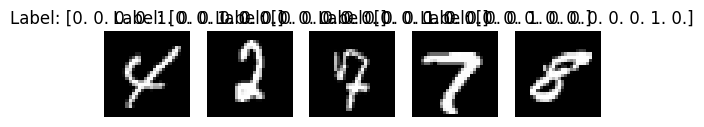

In [22]:
# Display a few images from the training set
num_images_to_display = 5
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

plt.show()

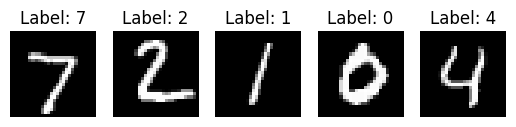

In [3]:
# Display a few images from the testing set
num_images_to_display = 5
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title(f"Label: {y_test[i]}")
    plt.axis('off')

plt.show()

# **2. Preprocessing**

In this phase, we perform crucial preprocessing steps to prepare our data for training. This involves reshaping and normalizing the input data, converting labels to one-hot encoding, and converting the dataset into NumPy arrays. Reshaping ensures compatibility with convolutional neural network (CNN) architectures, while normalization standardizes input values.

One-hot encoding transforms the categorical labels into a binary matrix, aiding the model in better understanding the output space. Converting data to NumPy arrays enhances computational efficiency and compatibility with numerical operations in Python.


### Data Conversion to NumPy Arrays

The dataset (`x_train`, `y_train`, `x_test`, `y_test`) is converted to NumPy arrays. This conversion is essential for efficient data manipulation and processing during the subsequent steps of the workflow.

In [7]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [8]:
x_test.shape

(10000, 28, 28)

### Data Splitting

The `train_test_split` function from the `sklearn.model_selection` module is used to split the training data into training and validation sets. This is a common practice in machine learning to evaluate model performance on a separate validation set during training. Here, 90% of the data is used for training (`x_train`, `y_train`), and 10% is reserved for validation (`x_val`, `y_val`).

We split our x_train data further into x_train and x_val --> dividing our existing train data into train and validation sets. out of 60k, 10% i.e. 6000 samples will be under validation set and rest - 54k will be under training set.

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=2)

The below code is reshaping and normalizing the input data for a Convolutional Neural Network (CNN). 
1. **Reshaping:** The input data (`x_train`, `x_val`, `x_test`) is reshaped to have dimensions `(samples, 28, 28, 1)`. This is done to match the input shape expected by a CNN. The original data had a shape of `(samples, 28, 28)` for each image, and the extra dimension of size 1 is added to represent the single channel (grayscale) of the images.

2. **Normalization:** The pixel values in the input images are normalized to the range `[0, 1]` by dividing each pixel value by 255. This is a common practice in neural network training to ensure that all input values are within a similar numerical range.

In [10]:
# Reshape input data for CNN
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_val = x_val.reshape((x_val.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

# Normalize input data
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

print('x_train:', x_train.shape)
print('x_validation:', x_val.shape)
print('x_test:', x_test.shape)
print('y_train:', y_train.shape)
print('y_validation:', y_val.shape)
print('y_test:', y_test.shape)

x_train: (54000, 28, 28, 1)
x_validation: (6000, 28, 28, 1)
x_test: (10000, 28, 28, 1)
y_train: (54000,)
y_validation: (6000,)
y_test: (10000,)


The below code performs one-hot encoding on the target labels (`y_train`, `y_val`, and `y_test`).

1. **One-Hot Encoding:**
   - The `to_categorical` function from Keras is used to convert the categorical integer labels into a binary matrix representation (one-hot encoding).
   - For example, if the original labels were `[2, 0, 1]`, after one-hot encoding, they would become:
     ```
     [[0, 0, 1],
      [1, 0, 0],
      [0, 1, 0]]
     ```
   - This encoding is commonly used in categorical classification problems, ensuring that the neural network can appropriately interpret and learn from the class labels.

The purpose of one-hot encoding is to represent categorical data in a format suitable for neural network training, where each category is represented as a binary vector.

In [ ]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print('y_train:', y_train.shape)
print('y_validation:', y_val.shape)
print('y_test:', y_test.shape)

# **3. Model Building**

This code builds a simple Convolutional Neural Network (CNN) using the Keras library with a TensorFlow backend. Here's a breakdown:

1. **Model Architecture:**
   - The model is initialized as a sequential model (`model = models.Sequential()`).
   - Three convolutional layers are added using `Conv2D` layers with ReLU activation functions.
   - Two max-pooling layers are added using `MaxPooling2D` layers to downsample the spatial dimensions of the feature maps.
   - The convolutional layers are followed by a flattening layer (`Flatten()`) to convert the 2D feature maps into a 1D vector.
   - Two dense (fully connected) layers are added with ReLU activation functions, and the last layer has 10 neurons with a softmax activation function, representing the output classes.

2. **Compilation:**
   - The model is compiled using the Adam optimizer (`optimizer='adam'`), which is a optimization algorithm.
   - The loss function is set to 'categorical_crossentropy', suitable for multi-class classification problems.
   - The metric for evaluation is set to accuracy (`metrics=['accuracy']`).

This CNN is designed for classifying images from the MNIST dataset into 10 categories (digits 0-9).

In [11]:
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
#from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.losses import CategoricalCrossentropy

# Build a simple convolutional neural network (CNN) model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))  

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# **4. Model Training**

Now that we have preprocessed the data and defined the convolutional neural network (CNN) model, let's train the model using the training dataset. We will run the training for 35 epochs and use the validation dataset to monitor the model's performance during training.

This code utilizes the fit method to train the CNN model on the preprocessed training data (x_train and y_train). The epochs parameter specifies the number of times the model will iterate over the entire training dataset, and the validation_data parameter is used to evaluate the model on the validation dataset after each epoch.

In [15]:
# Train the model
model.fit(x_train, y_train, epochs=35, validation_data=(x_val, y_val))

Epoch 1/35
1688/1688 [==============================] - 30s 18ms/step - loss: 0.0165 - accuracy: 0.9947 - val_loss: 0.0310 - val_accuracy: 0.9910
Epoch 2/35
1688/1688 [==============================] - 30s 18ms/step - loss: 0.0142 - accuracy: 0.9956 - val_loss: 0.0327 - val_accuracy: 0.9918
Epoch 3/35
1688/1688 [==============================] - 30s 18ms/step - loss: 0.0113 - accuracy: 0.9962 - val_loss: 0.0505 - val_accuracy: 0.9877
Epoch 4/35
1688/1688 [==============================] - 30s 18ms/step - loss: 0.0103 - accuracy: 0.9969 - val_loss: 0.0372 - val_accuracy: 0.9905
Epoch 5/35
1688/1688 [==============================] - 30s 18ms/step - loss: 0.0087 - accuracy: 0.9967 - val_loss: 0.0438 - val_accuracy: 0.9892
Epoch 6/35
1688/1688 [==============================] - 30s 18ms/step - loss: 0.0077 - accuracy: 0.9975 - val_loss: 0.0482 - val_accuracy: 0.9897
Epoch 7/35
1688/1688 [==============================] - 29s 17ms/step - loss: 0.0073 - accuracy: 0.9977 - val_loss: 0.0645 -

## Model Prediction

After training the convolutional neural network (CNN) model, use it to make predictions on the test dataset.

The evaluation process involves using the trained model to predict on the test data and comparing these predictions with the true labels to assess the model's performance.

The `model.evaluate` function in many deep learning frameworks, including Keras, typically performs the evaluation without explicitly storing the predictions. This is done for efficiency and memory optimization. In many cases, you may not need to keep the predictions after evaluating the model. When you call `model.evaluate(x_test, y_test, verbose=2)`, the `model` internally uses the trained weights to make predictions on the `x_test` data. It then compares these predicted results with the true labels `y_test` to calculate the loss and any specified metrics (such as accuracy).

If you want to keep the predictions for further analysis or visualization, you can explicitly use the `model.predict` method to get the predictions before calling `model.evaluate`. Hence in the following code, we will use the predict method followed by the evaluate method to calculate the accuracy and other eval metrics.

In [16]:
predictions = model.predict(x_test)

#test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
#print(f'\nTest accuracy: {test_acc}')

313/313 [==============================] - 2s 6ms/step


# **5. Model Evaluation**

Model is evaluated based on several metrics which provides insights into the model's performance, offering a more detailed understanding of its behavior on different classes.. The below code 

* calculates the accuracy using accuracy_score between the true labels (y_test) and the predicted labels (predictions).
* the confusion matrix is computed to analyze the performance of the classification algorithm. It is visualized using seaborn and matplotlib to provide a clear representation of true positive, true negative, false positive, and false negative predictions.
* The classification report presents precision, recall, and F1-score for each class.

Accuracy: 99.11%


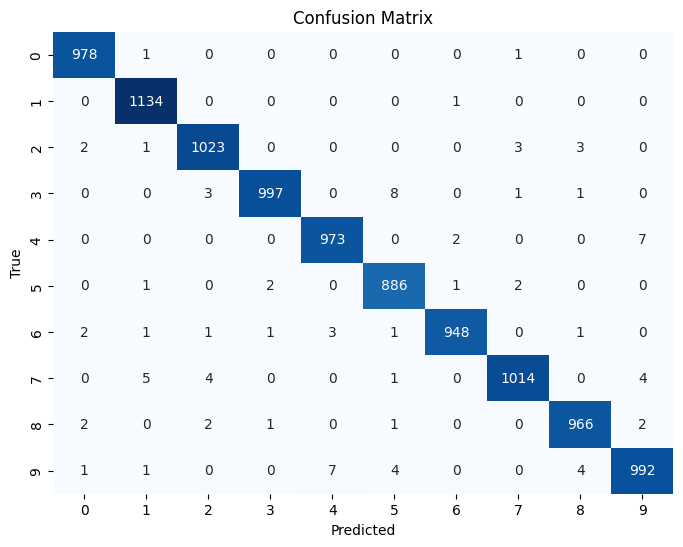

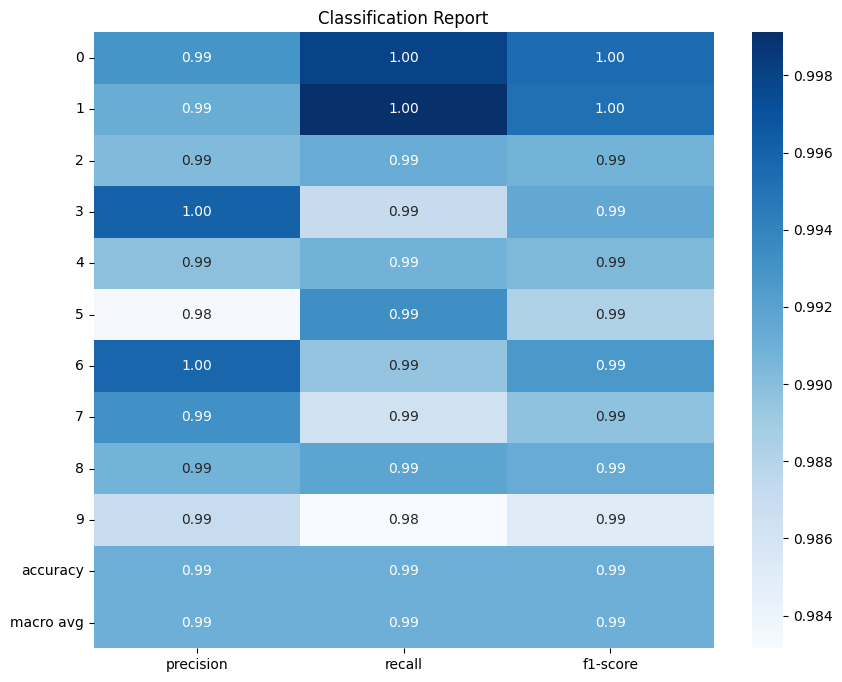

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Calculate accuracy
accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
conf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
class_report = classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), output_dict=True)

# Convert Classification Report to DataFrame for Visualization
report_df = pd.DataFrame(class_report).transpose()

# Visualize Classification Report
plt.figure(figsize=(10, 8))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues', cbar=True, fmt=".2f")
plt.title('Classification Report')
plt.show()

# **6. Visualize the result dataset**

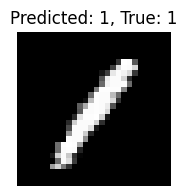

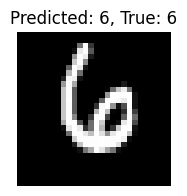

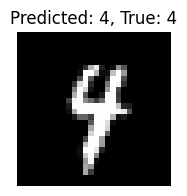

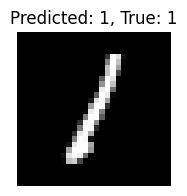

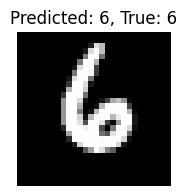

In [26]:
# Select random samples for visualization
num_samples = 5
random_indices = np.random.choice(len(x_test), num_samples)

# Visualize predicted results
for index in random_indices:
    # Get the predicted label
    predicted_label = np.argmax(predictions[index])

    # Get the true label
    true_label = np.argmax(y_test[index])

    # Display the image and predicted/true labels
    plt.figure(figsize=(2, 2))
    plt.imshow(x_test[index].reshape(28, 28), cmap='gray')
    plt.title(f'Predicted: {predicted_label}, True: {true_label}')
    plt.axis('off')
    plt.show()